## Import libraries

In [1]:
from math import sqrt, ceil
import os
from os import listdir
import shutil
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras_preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


## Define constants

In [2]:
DATASET_PATH = "../res/dataset/"
PATHS = {"train": DATASET_PATH+"train/", "val": DATASET_PATH+"val/", "test": DATASET_PATH+"test/"}
PATH_LABELS = {"normal": "NORMAL/", "bacteria": "BACTERIA/", "virus": "VIRUS/", "pneumonia": "PNEUMONIA/"}

LABELS = [item.lower() for item in os.listdir(PATHS["train"])]
MODEL_CP_DIR = "../res/modelcp/"
WEIGHT_PATH = {"local": MODEL_CP_DIR+"local/", "remote": MODEL_CP_DIR+"remote/"}

## Load the data

### Utility functions

In [3]:
def separate_pneuomia_classes(dir):
    label_dir = {"pneumonia": dir+PATH_LABELS["pneumonia"], "bacteria": dir+PATH_LABELS["bacteria"], "virus": dir+PATH_LABELS["virus"]}
    
    if os.path.exists(label_dir["bacteria"]) or os.path.exists(label_dir["virus"]):
        return
    else:
        os.mkdir(label_dir["bacteria"])
        os.mkdir(label_dir["virus"])
    
    for f in listdir(label_dir["pneumonia"]):
        shutil.move(label_dir["pneumonia"]+f, label_dir["virus"] if "virus" in f else label_dir["bacteria"])
        
    shutil.rmtree(label_dir["pneumonia"])

In [4]:
separate_pneuomia_classes(PATHS["train"])
separate_pneuomia_classes(PATHS["val"])
separate_pneuomia_classes(PATHS["test"])

BATCH_SIZE = 16

COLOR_MODE = "grayscale"
CLASS_MODE = "categorical"
RESCALE = 1./255
INPUT_SHAPE = (150, 150, 1)

datagen = ImageDataGenerator(rescale=RESCALE)

# Remember: data augmentation only on the train_generator --> Create 2 datagens
train_generator = datagen.flow_from_directory(PATHS["train"], target_size = INPUT_SHAPE[0:2], batch_size=BATCH_SIZE, color_mode=COLOR_MODE, class_mode=CLASS_MODE)
val_generator = datagen.flow_from_directory(PATHS["val"], target_size = INPUT_SHAPE[0:2], batch_size=BATCH_SIZE, color_mode=COLOR_MODE, class_mode=CLASS_MODE)
test_generator = datagen.flow_from_directory(PATHS["test"], target_size = INPUT_SHAPE[0:2], batch_size=BATCH_SIZE, color_mode=COLOR_MODE, class_mode=CLASS_MODE)

image_count = {"train": len(train_generator.filenames), "val": len(val_generator.filenames), "test": len(test_generator.filenames)}
steps_per_epoch = {"train": np.ceil(image_count["train"]/BATCH_SIZE), "val": np.ceil(image_count["val"]/BATCH_SIZE), "test": np.ceil(image_count["test"]/BATCH_SIZE)}

Found 5216 images belonging to 3 classes.
Found 16 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


### Show batch

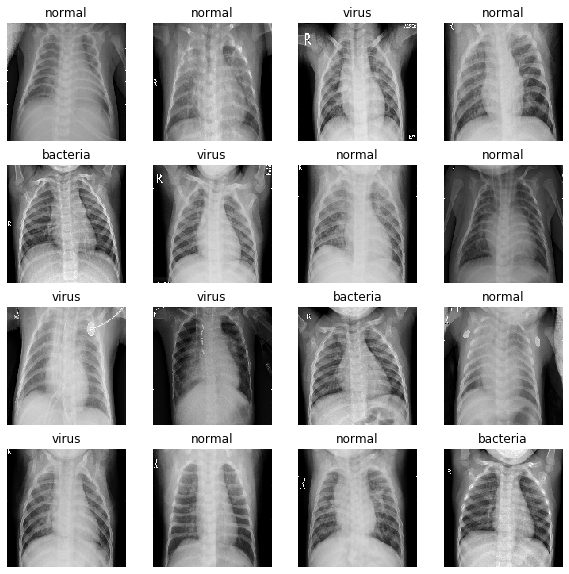

In [5]:
def show_batch(image_batch, label_batch, size):
  plt.figure(figsize=(10,10))
  rows_cols = ceil(sqrt(size))
  
  for n in range(size):
      ax = plt.subplot(rows_cols,rows_cols,n+1)
      plt.imshow(image_batch[n][:,:,0], cmap="gray")
      plt.title(LABELS[(label_batch[n]==1).tolist().index(True)])
      plt.axis('off')
      
image_batch, label_batch = next(train_generator)
show_batch(image_batch, label_batch, BATCH_SIZE)

## Model

In [6]:
SAVE = False
LOCAL = False
LOAD_WEIGHTS = False
POOL_SIZE = (2,2)
KERNEL_SIZE = (3,3)
ACTIVATION_HIDDEN_LAYERS = 'relu'
ACTIVATION_OUTPUT_LAYER = 'sigmoid'
LOSS = 'categorical_crossentropy'
OPTIMIZER = 'adam'
METRICS = ['accuracy']
EPOCH = 50

if tf.keras.backend.image_data_format() == 'channels_first':
    INPUT_SHAPE = (INPUT_SHAPE[-1], INPUT_SHAPE[0], INPUT_SHAPE[1])

model = Sequential()

model.add(Conv2D(32, KERNEL_SIZE, input_shape=INPUT_SHAPE))
model.add(Activation(ACTIVATION_HIDDEN_LAYERS))
model.add(MaxPooling2D(pool_size=POOL_SIZE))

model.add(Conv2D(32, KERNEL_SIZE))
model.add(Activation(ACTIVATION_HIDDEN_LAYERS))
model.add(MaxPooling2D(pool_size=POOL_SIZE))

model.add(Conv2D(64, KERNEL_SIZE))
model.add(Activation(ACTIVATION_HIDDEN_LAYERS))
model.add(MaxPooling2D(pool_size=POOL_SIZE))

model.add(Flatten()) # this converts 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation(ACTIVATION_HIDDEN_LAYERS))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation(ACTIVATION_OUTPUT_LAYER))

if SAVE:
    model.save_weights(WEIGHT_PATH["local"]+'weights.h5')
    model.save(WEIGHT_PATH["local"]+'model.h5')
else:
    if LOCAL:
         path = WEIGHT_PATH["local"]
    else:
        path = WEIGHT_PATH["remote"]
    
    if LOAD_WEIGHTS:    
        model.load_weights(path+"weights.h5") # Remember: then compile 
    else:
        model.load(path+"model.h5")
        
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
model.fit_generator(train_generator, validation_data=val_generator, epochs=EPOCH, steps_per_epoch=steps_per_epoch["train"], validation_steps=steps_per_epoch["val"])

# TODO
predict = model.predict_generator(test_generator, steps = steps_per_epoch["test"])

AttributeError: 'Sequential' object has no attribute 'load'